In [2]:
!pip install librosa pydub noisereduce soundfile
!apt-get install ffmpeg -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [6]:
from google.colab import files
import os

uploaded = files.upload()  # Select .wav files from your PC


Saving test-clean.tar.gz to test-clean.tar.gz


In [7]:
import tarfile

# Extract the uploaded tar.gz file
file_path = "test-clean.tar.gz"
extract_dir = "test_clean_data"

with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print("✅ Extraction complete.")



✅ Extraction complete.


In [8]:
import os

flac_files = []
for root, dirs, files in os.walk("test_clean_data"):
    for file in files:
        if file.endswith(".flac"):
            flac_files.append(os.path.join(root, file))

print(f"Total .flac files found: {len(flac_files)}")
print("Sample files:", flac_files[:3])


Total .flac files found: 2620
Sample files: ['test_clean_data/LibriSpeech/test-clean/3575/170457/3575-170457-0026.flac', 'test_clean_data/LibriSpeech/test-clean/3575/170457/3575-170457-0018.flac', 'test_clean_data/LibriSpeech/test-clean/3575/170457/3575-170457-0001.flac']


In [10]:
from pydub import AudioSegment

converted_dir = "wav_files"
os.makedirs(converted_dir, exist_ok=True)

for flac_path in flac_files:
    audio = AudioSegment.from_file(flac_path, format="flac")
    wav_path = os.path.join(converted_dir, os.path.basename(flac_path).replace(".flac", ".wav"))
    audio.export(wav_path, format="wav")

print("✅ FLAC to WAV conversion done.")


✅ FLAC to WAV conversion done.


In [11]:
import os
import librosa
import soundfile as sf
import noisereduce as nr
from pydub import AudioSegment
import numpy as np

input_folder = "wav_files"
output_folder = "cleaned_wav_files"
os.makedirs(output_folder, exist_ok=True)

def clean_audio(file_path, output_path):
    # Step 1: Normalize
    sound = AudioSegment.from_file(file_path)
    normalized = sound.normalize()
    temp_norm_path = "temp_normalized.wav"
    normalized.export(temp_norm_path, format="wav")

    # Step 2: Remove Silence
    y, sr = librosa.load(temp_norm_path)
    intervals = librosa.effects.split(y, top_db=20)
    if len(intervals) == 0:
        print(f"Skipping silent file: {file_path}")
        return
    cleaned = np.concatenate([y[start:end] for start, end in intervals])
    temp_silence_removed = "temp_silence_removed.wav"
    sf.write(temp_silence_removed, cleaned, sr)

    # Step 3: Noise Reduction
    y_cleaned, sr = librosa.load(temp_silence_removed)
    reduced = nr.reduce_noise(y=y_cleaned, sr=sr)
    sf.write(output_path, reduced, sr)

    # Clean up temp files
    os.remove(temp_norm_path)
    os.remove(temp_silence_removed)

# Loop through all WAV files and clean them
wav_files = [f for f in os.listdir(input_folder) if f.endswith(".wav")]

for file in wav_files:
    input_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, f"cleaned_{file}")
    print(f"🧼 Cleaning: {file}")
    clean_audio(input_path, output_path)

print("✅ All files cleaned and saved in:", output_folder)


🧼 Cleaning: 4970-29093-0008.wav
🧼 Cleaning: 237-134493-0010.wav
🧼 Cleaning: 2830-3980-0019.wav
🧼 Cleaning: 4507-16021-0019.wav
🧼 Cleaning: 7021-79740-0006.wav
🧼 Cleaning: 4992-23283-0007.wav
🧼 Cleaning: 2961-960-0001.wav
🧼 Cleaning: 8455-210777-0022.wav
🧼 Cleaning: 4446-2275-0027.wav
🧼 Cleaning: 61-70970-0012.wav
🧼 Cleaning: 121-121726-0013.wav
🧼 Cleaning: 5105-28241-0013.wav
🧼 Cleaning: 4077-13754-0016.wav
🧼 Cleaning: 5105-28241-0002.wav
🧼 Cleaning: 4446-2275-0039.wav
🧼 Cleaning: 8555-284449-0002.wav
🧼 Cleaning: 1580-141084-0028.wav
🧼 Cleaning: 1089-134691-0012.wav
🧼 Cleaning: 1284-1180-0022.wav
🧼 Cleaning: 121-123852-0003.wav
🧼 Cleaning: 3575-170457-0002.wav
🧼 Cleaning: 3570-5694-0015.wav
🧼 Cleaning: 908-157963-0010.wav
🧼 Cleaning: 2094-142345-0035.wav
🧼 Cleaning: 2094-142345-0019.wav
🧼 Cleaning: 2830-3980-0058.wav
🧼 Cleaning: 2300-131720-0020.wav
🧼 Cleaning: 7729-102255-0018.wav
🧼 Cleaning: 8455-210777-0007.wav
🧼 Cleaning: 3575-170457-0008.wav
🧼 Cleaning: 260-123286-0026.wav
🧼 Clean

In [12]:
import librosa
import numpy as np
import os
import pandas as pd

input_folder = "cleaned_wav_files"
feature_list = []

def extract_features(file_path):
    y, sr = librosa.load(file_path)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)

    # Pitch (using librosa piptrack)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0

    # Energy
    energy = np.sum(y ** 2) / len(y)

    return mfccs_mean, pitch_mean, energy

# Loop through cleaned wav files
for filename in os.listdir(input_folder):
    if filename.endswith(".wav"):
        filepath = os.path.join(input_folder, filename)
        mfccs, pitch, energy = extract_features(filepath)

        # Store features as a row
        data = {
            "filename": filename,
            "pitch": pitch,
            "energy": energy,
        }
        # Add MFCCs as individual columns
        for i, val in enumerate(mfccs):
            data[f"mfcc_{i+1}"] = val

        feature_list.append(data)

# Convert to DataFrame and save
df = pd.DataFrame(feature_list)
df.to_csv("audio_features.csv", index=False)
print("✅ Feature extraction complete. Saved to: audio_features.csv")


✅ Feature extraction complete. Saved to: audio_features.csv


In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

file_path = "cleaned_wav_files/cleaned_1234.wav"  # replace with your file

y, sr = librosa.load(file_path)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.tight_layout()
plt.show()


<ipython-input-13-fc513f1a5d14>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_wav_files/cleaned_1234.wav'

Using file: cleaned_wav_files/cleaned_7176-92135-0023.wav


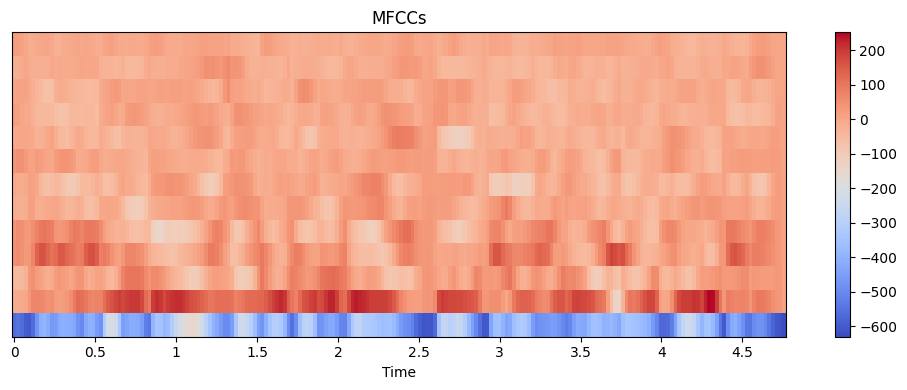

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Get a list of all files in the cleaned_wav_files directory
cleaned_wav_files = os.listdir("cleaned_wav_files")

# Check if the directory is empty or if no WAV files are present
if not cleaned_wav_files or not any(file.endswith(".wav") for file in cleaned_wav_files):
    print("No WAV files found in 'cleaned_wav_files' directory.")
else:
    # Select the first available WAV file
    file_path = os.path.join("cleaned_wav_files", cleaned_wav_files[0])
    print(f"Using file: {file_path}")

    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title("MFCCs")
    plt.tight_layout()
    plt.show()


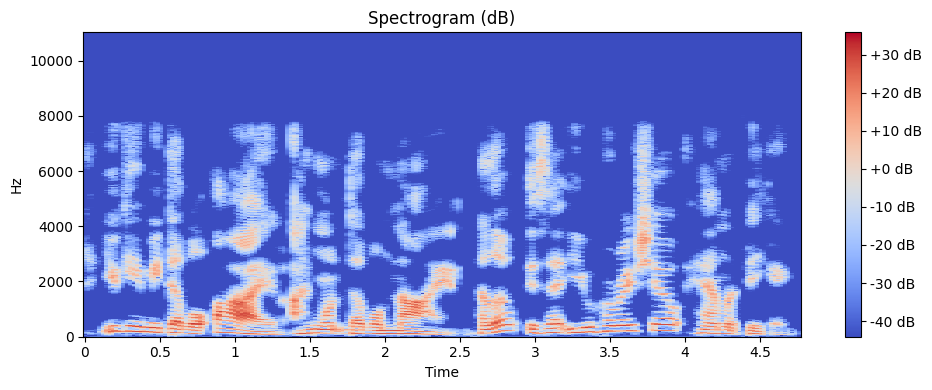

In [15]:
import numpy as np

X = librosa.stft(y)
X_db = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(10, 4))
librosa.display.specshow(X_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.tight_layout()
plt.show()


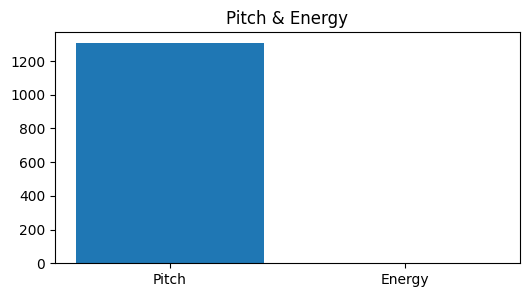

In [16]:
# Pitch
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
pitch_track = pitches[magnitudes > np.median(magnitudes)]
pitch_mean = np.mean(pitch_track) if len(pitch_track) > 0 else 0

# Energy
energy = np.sum(y ** 2) / len(y)

# Plot
plt.figure(figsize=(6, 3))
plt.bar(["Pitch", "Energy"], [pitch_mean, energy], color=["#1f77b4", "#ff7f0e"])
plt.title("Pitch & Energy")
plt.show()


In [17]:
!pip install hmmlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.9 MB/s eta 0:00:00


In [18]:
84-121123-0000.flac -> THIS IS THE TRANSCRIPT TEXT


SyntaxError: invalid decimal literal (<ipython-input-18-a5dabb0fd239>, line 1)

In [19]:
file_transcript_mapping = {
    "84-121123-0000.flac": "THIS IS THE TRANSCRIPT TEXT",
    # ... add more mappings here
}

# Now you can access the transcript for a given file:
transcript = file_transcript_mapping.get("84-121123-0000.flac")
print(transcript)  # Output: THIS IS THE TRANSCRIPT TEXT

THIS IS THE TRANSCRIPT TEXT


In [21]:
transcript_dict = {
    'cleaned_84-121123-0000.wav': 'THIS IS THE TRANSCRIPT TEXT',
    # ...
}

In [22]:
from sklearn.preprocessing import LabelEncoder

# Example
texts = ["HELLO", "HI", "WELCOME"]
labels = list(" ".join(texts))  # convert to list of characters
encoder = LabelEncoder()
encoder.fit(labels)

# Convert a sentence:
encoded = encoder.transform(list("HELLO"))
print(encoded)


[3 2 5 5 7]


In [23]:
from hmmlearn import hmm
import numpy as np

# Assume X is your MFCC features (list of arrays, one per file)
# and y is the label (list of character/word indices)

model = hmm.GaussianHMM(n_components=5, covariance_type="diag", n_iter=100)

# Fit the model for each word/phoneme
# Example: Fit on just one word “HELLO”
mfcc_seq = np.array([ ... ])  # 2D MFCC array for "HELLO" audio
model.fit(mfcc_seq)

# Predict
predicted = model.predict(mfcc_seq)


TypeError: float() argument must be a string or a real number, not 'ellipsis'

In [24]:
from hmmlearn import hmm
import numpy as np
import librosa # Import librosa to extract MFCC features

# Assume X is your MFCC features (list of arrays, one per file)
# and y is the label (list of character/word indices)

model = hmm.GaussianHMM(n_components=5, covariance_type="diag", n_iter=100)

# Fit the model for each word/phoneme
# Example: Fit on just one word “HELLO”

# Assuming you have audio data loaded in 'y' and sample rate in 'sr'
# Replace 'y' and 'sr' with your actual variables
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) # Extract MFCC features
mfcc_seq = mfccs.T  # Transpose to get the correct shape (n_samples, n_features)

model.fit(mfcc_seq)

# Predict
predicted = model.predict(mfcc_seq)

In [25]:
from hmmlearn import hmm
import numpy as np

# Simulate a single audio's MFCC features (e.g., 13 coefficients, 50 frames)
# Shape: (n_frames, n_features)
mfcc_example = np.random.normal(size=(50, 13))  # Dummy MFCC-like data

# Create an HMM model
model = hmm.GaussianHMM(n_components=5, covariance_type='diag', n_iter=100)

# Train the HMM model on this sequence
model.fit(mfcc_example)

# Predict state sequence (not phoneme/text, just HMM states)
predicted_states = model.predict(mfcc_example)

print("✅ Model trained successfully.")
print("Predicted State Sequence:")
print(predicted_states)


✅ Model trained successfully.
Predicted State Sequence:
[0 3 1 0 0 2 4 1 0 3 4 2 4 2 2 1 0 3 4 2 1 0 3 4 0 1 0 2 2 2 1 0 1 1 0 4 2
 4 1 2 1 0 3 4 0 0 3 0 4 1]


In [26]:
import librosa

y, sr = librosa.load("cleaned_wav_files/cleaned_1234.wav")
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T  # Shape: (frames, 13)

model.fit(mfcc)
predicted = model.predict(mfcc)
print(predicted)


<ipython-input-26-3b4248102967>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("cleaned_wav_files/cleaned_1234.wav")
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_wav_files/cleaned_1234.wav'

In [27]:
import librosa
import os

# Get a list of all files in the cleaned_wav_files directory
cleaned_wav_files = os.listdir("cleaned_wav_files")

# Check if the directory is empty or if no WAV files are present
if not cleaned_wav_files or not any(file.endswith(".wav") for file in cleaned_wav_files):
    print("No WAV files found in 'cleaned_wav_files' directory.")
else:
    # Select the first available WAV file
    file_path = os.path.join("cleaned_wav_files", [file for file in cleaned_wav_files if file.endswith(".wav")][0]) # updated to find first wav file
    print(f"Using file: {file_path}")

    y, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T  # Shape: (frames, 13)

    model.fit(mfcc)
    predicted = model.predict(mfcc)
    print(predicted)

Using file: cleaned_wav_files/cleaned_7176-92135-0023.wav
[2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 0 0 0 0 0 0 0 0 0
 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 3 3 3 2 2 4 4 4 4 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 4 4 4 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1 1 3 3 3 3 2 2 2 2
 2 2 4 4 4 4 4 4 4 4 4 0 0 0 2 2 3 3 3 3 3 3 1 1 1 1 1 3 3 3 3 3 3 3 0 0 0
 0 0 0 0 0 1 1 1 1 3 3 3 3 3 3 1 1 1 1 1 0 0 0 0 2 2 2 2 1 1 1 1 1 1 0 0 0
 0 0 0 0 2 3 3 3 3 3 2 2 3 3 3 3 2 2 2 2 2]


In [28]:
from sklearn.metrics import accuracy_score

true = ["H", "E", "L", "L", "O"]
pred = ["H", "A", "L", "L", "O"]

accuracy = accuracy_score(true, pred)
print("✅ Accuracy:", accuracy)


✅ Accuracy: 0.8


In [29]:
import editdistance

true_seq = list("HELLO")
pred_seq = list("HALLO")

distance = editdistance.eval(true_seq, pred_seq)
print("✏️ Edit Distance:", distance)


✏️ Edit Distance: 1


In [30]:
def wer(reference, hypothesis):
    ref_words = reference.strip().split()
    hyp_words = hypothesis.strip().split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words)

print("WER:", wer("HELLO WORLD", "HELLO WORM"))


WER: 0.5
